# DFW Restaurant Dataset Collection via Google Places API

This notebook implements a comprehensive data collection strategy to build a dataset of 1,000 restaurants in the Dallas-Fort Worth (DFW) metropolitan area using the Google Places API.

## Objectives
- Create a geographically balanced dataset covering the entire DFW metro area
- Collect rich information about each restaurant (location, ratings, hours, photos, etc.)
- Implement proper deduplication and rate limiting
- Ensure data quality and completeness

## Implementation Strategy
We'll use a multi-step approach:
1. Define the DFW metro area and create a grid of search tiles
2. Query each tile using the Nearby Search API to discover restaurants
3. Supplement with Text Search for specific cuisine types
4. Deduplicate results based on place_id
5. Fetch detailed information for each unique restaurant
6. Download representative photos
7. Export the dataset in a structured format


In [1]:
# Setup and Configuration

## Install required packages
%pip install -q googlemaps pandas numpy matplotlib shapely geopandas tqdm python-dotenv requests


Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import necessary libraries
import os
import time
import math
import json
from datetime import datetime
from pathlib import Path
from tqdm.notebook import tqdm
from dotenv import load_dotenv

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
import requests
import googlemaps

# Load environment variables from .env file
load_dotenv()

# Access API key from environment variables
API_KEY = os.getenv("GOOGLE_PLACES_API_KEY")

if not API_KEY:
    raise ValueError("API_KEY not found. Make sure you have a .env file with GOOGLE_PLACES_API_KEY defined.")

# Initialize Google Maps client
gmaps = googlemaps.Client(key=API_KEY)

print("Setup complete! Google Maps client initialized.")


Matplotlib is building the font cache; this may take a moment.


Setup complete! Google Maps client initialized.


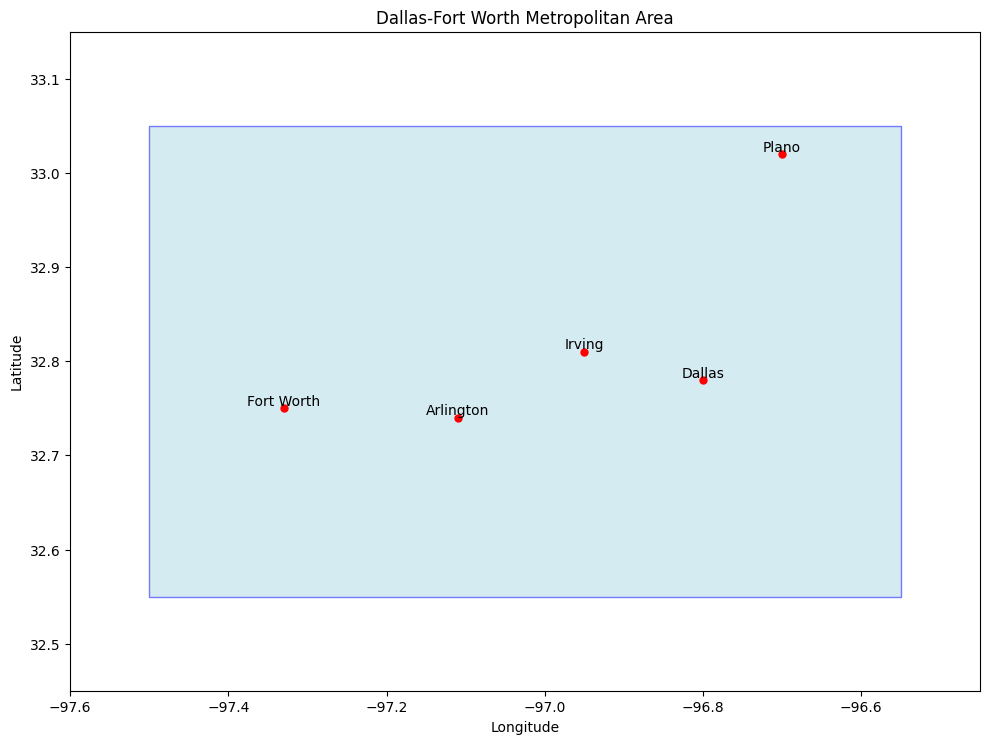

In [3]:
# 1. Define the DFW Metro Area

## Define the DFW bounding box
# These coordinates roughly cover the Dallas-Fort Worth metropolitan area
DFW_BOUNDS = {
    'min_lat': 32.55,  # Southern boundary
    'max_lat': 33.05,  # Northern boundary
    'min_lng': -97.50, # Western boundary
    'max_lng': -96.55  # Eastern boundary
}

# Create a visualization of the DFW area
def plot_dfw_area():
    # Create a polygon representing the DFW area
    dfw_polygon = box(
        DFW_BOUNDS['min_lng'], 
        DFW_BOUNDS['min_lat'], 
        DFW_BOUNDS['max_lng'], 
        DFW_BOUNDS['max_lat']
    )
    
    # Convert to GeoDataFrame for plotting
    dfw_gdf = gpd.GeoDataFrame(geometry=[dfw_polygon], crs="EPSG:4326")
    
    # Plot the DFW area
    fig, ax = plt.subplots(figsize=(10, 8))
    dfw_gdf.plot(ax=ax, alpha=0.5, color='lightblue', edgecolor='blue')
    
    # Add labels for major cities
    cities = {
        'Dallas': (-96.80, 32.78),
        'Fort Worth': (-97.33, 32.75),
        'Arlington': (-97.11, 32.74),
        'Plano': (-96.70, 33.02),
        'Irving': (-96.95, 32.81),
        'Frisco': (-96.82, 33.15)
    }
    
    for city, (lng, lat) in cities.items():
        if (DFW_BOUNDS['min_lng'] <= lng <= DFW_BOUNDS['max_lng'] and 
            DFW_BOUNDS['min_lat'] <= lat <= DFW_BOUNDS['max_lat']):
            ax.plot(lng, lat, 'ro', markersize=5)
            ax.text(lng, lat, city, fontsize=10, ha='center', va='bottom')
    
    # Set labels and title
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title('Dallas-Fort Worth Metropolitan Area')
    
    # Set axis limits
    ax.set_xlim([DFW_BOUNDS['min_lng'] - 0.1, DFW_BOUNDS['max_lng'] + 0.1])
    ax.set_ylim([DFW_BOUNDS['min_lat'] - 0.1, DFW_BOUNDS['max_lat'] + 0.1])
    
    plt.tight_layout()
    return fig, ax

# Plot the DFW area
fig, ax = plot_dfw_area()


Created grid with 4984 tiles (56x89)


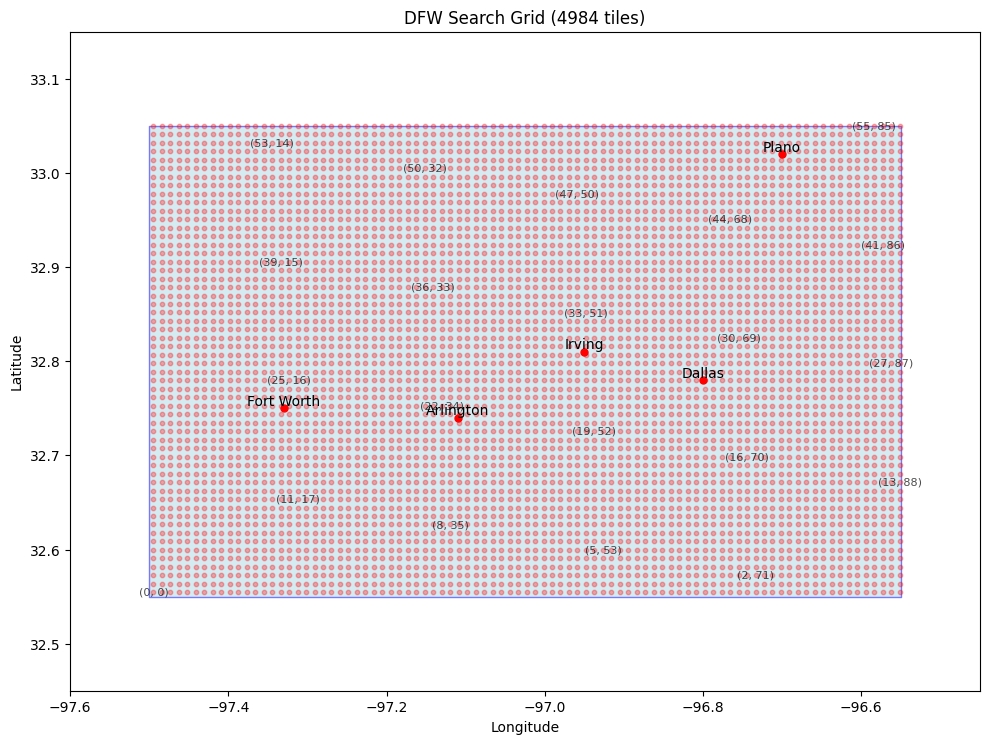

In [4]:
# 2. Create a Grid of Search Tiles

# Function to create a grid of tiles covering the DFW area
def create_search_grid(bounds, tile_size_km=1.0):
    """
    Create a grid of search tiles covering the specified geographic bounds.
    
    Parameters:
    - bounds: Dictionary with min_lat, max_lat, min_lng, max_lng
    - tile_size_km: Approximate size of each tile in kilometers
    
    Returns:
    - List of dictionaries, each containing center coordinates and radius for a tile
    """
    # Approximate conversion from km to degrees (varies by latitude)
    # At around 33° latitude (DFW area), 1° latitude ≈ 111 km, 1° longitude ≈ 95 km
    lat_km_to_deg = 1.0 / 111.0
    lng_km_to_deg = 1.0 / (111.0 * math.cos(math.radians((bounds['min_lat'] + bounds['max_lat']) / 2)))
    
    # Calculate tile sizes in degrees
    lat_step = tile_size_km * lat_km_to_deg
    lng_step = tile_size_km * lng_km_to_deg
    
    # Calculate number of tiles needed in each direction
    lat_tiles = math.ceil((bounds['max_lat'] - bounds['min_lat']) / lat_step)
    lng_tiles = math.ceil((bounds['max_lng'] - bounds['min_lng']) / lng_step)
    
    # Create tiles
    tiles = []
    for i in range(lat_tiles):
        for j in range(lng_tiles):
            # Calculate center of this tile
            center_lat = bounds['min_lat'] + (i + 0.5) * lat_step
            center_lng = bounds['min_lng'] + (j + 0.5) * lng_step
            
            # Add tile to list
            tiles.append({
                'center': (center_lat, center_lng),
                'radius': (tile_size_km * 1000) / 2,  # Convert to meters and halve for radius
                'index': (i, j)
            })
    
    print(f"Created grid with {len(tiles)} tiles ({lat_tiles}x{lng_tiles})")
    return tiles

# Create a grid of search tiles (1 km each)
search_tiles = create_search_grid(DFW_BOUNDS, tile_size_km=1.0)

# Visualize the search grid
def plot_search_grid(tiles, bounds):
    fig, ax = plot_dfw_area()
    
    # Plot each tile as a point
    lats = [tile['center'][0] for tile in tiles]
    lngs = [tile['center'][1] for tile in tiles]
    
    ax.scatter(lngs, lats, c='red', alpha=0.3, s=10)
    
    # Add grid indices for a few tiles to show the pattern
    for i in range(0, len(tiles), max(1, len(tiles) // 20)):
        tile = tiles[i]
        ax.text(tile['center'][1], tile['center'][0], 
                f"{tile['index']}", fontsize=8, 
                ha='center', va='center', alpha=0.7)
    
    plt.title(f"DFW Search Grid ({len(tiles)} tiles)")
    return fig, ax

# Plot the search grid
fig, ax = plot_search_grid(search_tiles, DFW_BOUNDS)


In [5]:
# 3. API Rate Limiting and Quota Management

# Define a rate limiter class to manage API calls
class RateLimiter:
    def __init__(self, calls_per_second=3, calls_per_day=None):
        """
        Initialize a rate limiter to manage API call frequency.
        
        Parameters:
        - calls_per_second: Maximum number of calls allowed per second
        - calls_per_day: Maximum number of calls allowed per day (optional)
        """
        self.calls_per_second = calls_per_second
        self.calls_per_day = calls_per_day
        self.last_call_time = 0
        self.daily_calls = 0
        self.daily_reset_time = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    
    def wait_if_needed(self):
        """
        Wait if necessary to comply with rate limits.
        Returns True if the call is allowed, False if daily limit exceeded.
        """
        # Check if we need to reset daily counter
        now = datetime.now()
        if now.date() > self.daily_reset_time.date():
            self.daily_calls = 0
            self.daily_reset_time = now.replace(hour=0, minute=0, second=0, microsecond=0)
        
        # Check daily limit
        if self.calls_per_day and self.daily_calls >= self.calls_per_day:
            print(f"Daily limit of {self.calls_per_day} calls reached. Try again tomorrow.")
            return False
        
        # Calculate time to wait for per-second limit
        current_time = time.time()
        time_since_last = current_time - self.last_call_time
        time_to_wait = max(0, (1.0 / self.calls_per_second) - time_since_last)
        
        if time_to_wait > 0:
            time.sleep(time_to_wait)
        
        # Update tracking variables
        self.last_call_time = time.time()
        self.daily_calls += 1
        
        return True

# Create a rate limiter (3 calls per second, well below Google's limit)
rate_limiter = RateLimiter(calls_per_second=3)

# Function to handle API errors with exponential backoff
def api_call_with_backoff(func, *args, **kwargs):
    """
    Make an API call with exponential backoff for handling rate limits and errors.
    
    Parameters:
    - func: The API function to call
    - *args, **kwargs: Arguments to pass to the function
    
    Returns:
    - API response or None if all retries failed
    """
    max_retries = 5
    base_delay = 2  # seconds
    
    for attempt in range(max_retries):
        # Wait if needed according to our rate limiter
        if not rate_limiter.wait_if_needed():
            return None
        
        try:
            # Make the API call
            response = func(*args, **kwargs)
            return response
            
        except Exception as e:
            # Handle different types of errors
            if "OVER_QUERY_LIMIT" in str(e):
                # Exponential backoff
                delay = base_delay * (2 ** attempt)
                print(f"Rate limit exceeded. Retrying in {delay} seconds...")
                time.sleep(delay)
            elif "INVALID_REQUEST" in str(e) or "REQUEST_DENIED" in str(e):
                print(f"API Error: {e}")
                return None
            else:
                # For network errors, etc.
                delay = base_delay * (2 ** attempt)
                print(f"Error: {e}. Retrying in {delay} seconds...")
                time.sleep(delay)
    
    print("Maximum retries reached. Giving up on this request.")
    return None

print("Rate limiter and API error handling configured.")


Rate limiter and API error handling configured.


In [7]:
# 4. Nearby Search Implementation

# Function to search for restaurants in a specific tile
def search_restaurants_in_tile(tile, page_token=None):
    """
    Search for restaurants within a specific tile using the Google Places API.
    
    Parameters:
    - tile: Dictionary containing center coordinates and radius
    - page_token: Token for pagination (optional)
    
    Returns:
    - List of restaurant results
    - Next page token (if available)
    """
    if page_token:
        # If we have a page token, use it to get the next page of results
        response = api_call_with_backoff(
            gmaps.places,
            page_token=page_token
        )
    else:
        # Initial search
        response = api_call_with_backoff(
            gmaps.places_nearby,
            location=tile['center'],
            radius=tile['radius'],
            type='restaurant'
        )
    
    if not response:
        return [], None
    
    # Extract results and next_page_token
    results = response.get('results', [])
    next_page_token = response.get('next_page_token')
    
    return results, next_page_token

# Function to collect restaurants from all tiles
def collect_restaurants_from_tiles(tiles, max_pages_per_tile=3, max_restaurants=None):
    """
    Collect restaurant data from all tiles.
    
    Parameters:
    - tiles: List of tile dictionaries
    - max_pages_per_tile: Maximum number of pages to fetch per tile
    - max_restaurants: Maximum number of restaurants to collect (optional)
    
    Returns:
    - List of restaurant data dictionaries
    """
    all_restaurants = []
    place_ids_seen = set()
    
    # Create a progress bar
    pbar = tqdm(total=len(tiles), desc="Processing tiles")
    
    for tile_idx, tile in enumerate(tiles):
        # For each tile, get up to max_pages_per_tile pages of results
        page_token = None
        pages_fetched = 0
        
        while pages_fetched < max_pages_per_tile:
            # Search for restaurants in this tile
            results, next_page_token = search_restaurants_in_tile(tile, page_token)
            
            # Process results
            for result in results:
                place_id = result.get('place_id')
                
                # Skip if we've seen this place before
                if place_id in place_ids_seen:
                    continue
                
                # Add to our collection
                place_ids_seen.add(place_id)
                
                # Add tile information to the result
                result['source_tile'] = tile['index']
                all_restaurants.append(result)
                
                # Check if we've reached the maximum
                if max_restaurants and len(all_restaurants) >= max_restaurants:
                    pbar.update(len(tiles) - tile_idx)
                    pbar.close()
                    return all_restaurants
            
            # Update counters
            pages_fetched += 1
            
            # If there's no next page, break
            if not next_page_token:
                break
                
            # Otherwise, prepare for the next page
            page_token = next_page_token
            
            # Wait a bit before requesting the next page (Google requires this)
            time.sleep(2)
        
        # Update progress bar
        pbar.update(1)
        
        # Print occasional status updates
        if (tile_idx + 1) % 10 == 0:
            print(f"Processed {tile_idx + 1}/{len(tiles)} tiles. Found {len(all_restaurants)} unique restaurants so far.")
    
    pbar.close()
    return all_restaurants

# Test the search on a small subset of tiles (just 5 for now)
test_tiles = search_tiles[:5]
print(f"Testing search on {len(test_tiles)} tiles...")

test_restaurants = collect_restaurants_from_tiles(test_tiles, max_pages_per_tile=2)
print(f"Found {len(test_restaurants)} unique restaurants in test tiles.")

# Convert to DataFrame for easier analysis
test_df = pd.DataFrame(test_restaurants)

# Display the first few restaurants
if len(test_df) > 0:
    # Select columns to display
    display_cols = ['name', 'rating', 'user_ratings_total', 'vicinity']
    display_cols = [col for col in display_cols if col in test_df.columns]
    
    print("\nSample of restaurants found:")
    display(test_df[display_cols].head())


Testing search on 5 tiles...


Processing tiles:   0%|          | 0/5 [00:00<?, ?it/s]

Found 0 unique restaurants in test tiles.


In [8]:
# 5. Keyword Search for Additional Coverage

# Define cuisine types and food categories for text search
CUISINE_KEYWORDS = [
    "mexican restaurant",
    "italian restaurant",
    "chinese restaurant",
    "bbq restaurant",
    "steakhouse",
    "seafood restaurant",
    "thai restaurant",
    "indian restaurant",
    "sushi restaurant",
    "vietnamese restaurant",
    "korean restaurant",
    "tex-mex restaurant",
    "food truck",
    "diner",
    "cafe",
    "bakery",
    "breakfast",
    "brunch",
    "taqueria",
    "pizzeria"
]

# Function to perform text search for specific cuisine types
def search_by_cuisine(keyword, location, radius_meters=25000, max_pages=2):
    """
    Search for restaurants of a specific cuisine type.
    
    Parameters:
    - keyword: Cuisine type or keyword
    - location: (lat, lng) tuple for the center of the search
    - radius_meters: Search radius in meters
    - max_pages: Maximum number of pages to fetch
    
    Returns:
    - List of restaurant results
    """
    all_results = []
    place_ids_seen = set()
    page_token = None
    pages_fetched = 0
    
    while pages_fetched < max_pages:
        if page_token:
            response = api_call_with_backoff(
                gmaps.places,
                page_token=page_token
            )
        else:
            response = api_call_with_backoff(
                gmaps.places,
                query=keyword,
                location=location,
                radius=radius_meters
            )
        
        if not response:
            break
            
        results = response.get('results', [])
        
        # Process results
        for result in results:
            place_id = result.get('place_id')
            if place_id not in place_ids_seen:
                place_ids_seen.add(place_id)
                result['source_keyword'] = keyword
                all_results.append(result)
        
        # Update counters
        pages_fetched += 1
        
        # Check for next page
        next_page_token = response.get('next_page_token')
        if not next_page_token:
            break
            
        page_token = next_page_token
        time.sleep(2)  # Wait before requesting next page
    
    return all_results

# Function to collect restaurants using keyword search
def collect_restaurants_by_cuisine(keywords, center_location, max_restaurants=None):
    """
    Collect restaurant data using keyword search.
    
    Parameters:
    - keywords: List of cuisine types or keywords
    - center_location: (lat, lng) tuple for the center of the search
    - max_restaurants: Maximum number of restaurants to collect (optional)
    
    Returns:
    - List of restaurant data dictionaries
    """
    all_restaurants = []
    place_ids_seen = set()
    
    # Create a progress bar
    pbar = tqdm(total=len(keywords), desc="Processing cuisine keywords")
    
    for keyword in keywords:
        # Search for restaurants with this keyword
        results = search_by_cuisine(keyword, center_location)
        
        # Process results
        for result in results:
            place_id = result.get('place_id')
            
            # Skip if we've seen this place before
            if place_id in place_ids_seen:
                continue
                
            # Add to our collection
            place_ids_seen.add(place_id)
            all_restaurants.append(result)
            
            # Check if we've reached the maximum
            if max_restaurants and len(all_restaurants) >= max_restaurants:
                pbar.update(len(keywords) - pbar.n)
                pbar.close()
                return all_restaurants
        
        # Update progress bar
        pbar.update(1)
    
    pbar.close()
    return all_restaurants

# Test cuisine keyword search with a couple of keywords
# Use the center of DFW as the search location
dfw_center = (
    (DFW_BOUNDS['min_lat'] + DFW_BOUNDS['max_lat']) / 2,
    (DFW_BOUNDS['min_lng'] + DFW_BOUNDS['max_lng']) / 2
)

print(f"Testing cuisine keyword search from DFW center: {dfw_center}")

# Test with just 2 cuisine keywords
test_keywords = CUISINE_KEYWORDS[:2]
print(f"Testing with keywords: {test_keywords}")

test_cuisine_restaurants = collect_restaurants_by_cuisine(test_keywords, dfw_center)
print(f"Found {len(test_cuisine_restaurants)} unique restaurants using cuisine keywords.")

# Convert to DataFrame for easier analysis
test_cuisine_df = pd.DataFrame(test_cuisine_restaurants)

# Display the first few restaurants
if len(test_cuisine_df) > 0:
    # Select columns to display
    display_cols = ['name', 'rating', 'user_ratings_total', 'vicinity', 'source_keyword']
    display_cols = [col for col in display_cols if col in test_cuisine_df.columns]
    
    print("\nSample of restaurants found via cuisine search:")
    display(test_cuisine_df[display_cols].head())


Testing cuisine keyword search from DFW center: (32.8, -97.025)
Testing with keywords: ['mexican restaurant', 'italian restaurant']


Processing cuisine keywords:   0%|          | 0/2 [00:00<?, ?it/s]

Found 80 unique restaurants using cuisine keywords.

Sample of restaurants found via cuisine search:


,name,rating,user_ratings_total,source_keyword
0,EL Paisano,3.8,2280,mexican restaurant
1,Los Molcajetes,4.5,4944,mexican restaurant
2,Las Palmas Tex-Mex,4.5,1787,mexican restaurant
3,Rj Mexican Cuisine,4.8,10955,mexican restaurant
4,Miriam Cocina Latina,4.6,1135,mexican restaurant


In [10]:
# 6. Fetch Detailed Restaurant Information

# Define the fields we want to retrieve for each restaurant
PLACE_DETAILS_FIELDS = [
    # Basic
    'place_id', 'name', 'formatted_address', 'adr_address',
    'geometry', 'business_status', 'vicinity',
    # Contact
    'formatted_phone_number', 'international_phone_number',
    'website', 'url',
    # Atmosphere
    'rating', 'user_ratings_total', 'price_level',
    'current_opening_hours', 'secondary_opening_hours',
    'photo',          # photo references
    'review',         # full reviews (can be hefty)
    'editorial_summary'
]

# Function to fetch detailed information for a restaurant
def fetch_restaurant_details(place_id):
    """
    Fetch detailed information for a restaurant using its place_id.
    
    Parameters:
    - place_id: The Google Places ID for the restaurant
    
    Returns:
    - Dictionary containing detailed restaurant information
    """
    response = api_call_with_backoff(
        gmaps.place,
        place_id=place_id,
        fields=PLACE_DETAILS_FIELDS
    )
    
    if not response:
        return None
        
    # Extract the result
    result = response.get('result', {})
    
    return result

# Function to fetch details for multiple restaurants
def fetch_details_for_restaurants(restaurants, max_restaurants=None):
    """
    Fetch detailed information for multiple restaurants.
    
    Parameters:
    - restaurants: List of restaurant dictionaries (must contain 'place_id')
    - max_restaurants: Maximum number of restaurants to process (optional)
    
    Returns:
    - List of dictionaries containing detailed restaurant information
    """
    detailed_restaurants = []
    
    # Limit the number of restaurants if specified
    if max_restaurants:
        restaurants = restaurants[:max_restaurants]
    
    # Create a progress bar
    pbar = tqdm(total=len(restaurants), desc="Fetching restaurant details")
    
    for restaurant in restaurants:
        place_id = restaurant.get('place_id')
        
        if not place_id:
            pbar.update(1)
            continue
            
        # Fetch details
        details = fetch_restaurant_details(place_id)
        
        if details:
            # Add source information if available
            if 'source_tile' in restaurant:
                details['source_tile'] = restaurant['source_tile']
            if 'source_keyword' in restaurant:
                details['source_keyword'] = restaurant['source_keyword']
                
            detailed_restaurants.append(details)
        
        # Update progress bar
        pbar.update(1)
    
    pbar.close()
    return detailed_restaurants

# Test fetching details for a small number of restaurants
# Combine restaurants from both test sets
all_test_restaurants = test_restaurants + test_cuisine_restaurants
unique_test_restaurants = []
seen_place_ids = set()

for restaurant in all_test_restaurants:
    place_id = restaurant.get('place_id')
    if place_id and place_id not in seen_place_ids:
        seen_place_ids.add(place_id)
        unique_test_restaurants.append(restaurant)

# Fetch details for just a few restaurants
num_to_fetch = min(5, len(unique_test_restaurants))
print(f"Fetching details for {num_to_fetch} test restaurants...")

detailed_test_restaurants = fetch_details_for_restaurants(unique_test_restaurants, max_restaurants=num_to_fetch)
print(f"Successfully fetched details for {len(detailed_test_restaurants)} restaurants.")

# Convert to DataFrame for easier analysis
detailed_df = pd.DataFrame(detailed_test_restaurants)

# Display some key information
if len(detailed_df) > 0:
    # Select columns to display
    basic_cols = ['name', 'formatted_address', 'rating', 'user_ratings_total', 'price_level']
    available_cols = [col for col in basic_cols if col in detailed_df.columns]
    
    print("\nDetailed restaurant information:")
    display(detailed_df[available_cols])
    
    # Check what other information we have
    print("\nAvailable fields in the detailed data:")
    print(detailed_df.columns.tolist())


Fetching details for 5 test restaurants...


Fetching restaurant details:   0%|          | 0/5 [00:00<?, ?it/s]

Successfully fetched details for 5 restaurants.

Detailed restaurant information:


,name,formatted_address,rating,user_ratings_total,price_level
0,EL Paisano,"305 S Carroll Ave, Dallas, TX 75226, USA",3.8,2280,1
1,Los Molcajetes,"4320 Western Center Blvd, Fort Worth, TX 76137...",4.5,4944,2
2,Las Palmas Tex-Mex,"2708 Routh St, Dallas, TX 75201, USA",4.5,1787,2
3,Rj Mexican Cuisine,"1701 N Market St #102, Dallas, TX 75202, USA",4.8,10955,2
4,Miriam Cocina Latina,"2015 Woodall Rodgers Fwy, Dallas, TX 75201, USA",4.6,1135,2



Available fields in the detailed data:
['adr_address', 'business_status', 'current_opening_hours', 'formatted_address', 'geometry', 'name', 'photos', 'place_id', 'price_level', 'rating', 'reviews', 'url', 'user_ratings_total', 'vicinity', 'source_keyword', 'editorial_summary', 'formatted_phone_number', 'international_phone_number', 'secondary_opening_hours', 'website']


In [11]:
# 7. Download Restaurant Photos

# Function to download a photo using its reference
def download_photo(photo_reference, max_width=1600, max_height=1600):
    """
    Download a photo using its reference from the Google Places API.
    
    Parameters:
    - photo_reference: The photo reference string from the API
    - max_width: Maximum width of the photo
    - max_height: Maximum height of the photo
    
    Returns:
    - Photo data as bytes, or None if download failed
    """
    if not photo_reference:
        return None
        
    # Construct the URL for the photo
    url = f"https://maps.googleapis.com/maps/api/place/photo"
    params = {
        'maxwidth': max_width,
        'maxheight': max_height,
        'photoreference': photo_reference,
        'key': API_KEY
    }
    
    try:
        # Wait for rate limiter
        rate_limiter.wait_if_needed()
        
        # Make the request
        response = requests.get(url, params=params)
        
        # Check if the request was successful
        if response.status_code == 200:
            return response.content
        else:
            print(f"Error downloading photo: {response.status_code}")
            return None
            
    except Exception as e:
        print(f"Error downloading photo: {e}")
        return None

# Function to download photos for a restaurant
def download_restaurant_photos(restaurant, max_photos=3, photo_dir='restaurant_photos'):
    """
    Download photos for a restaurant and save them to disk.
    
    Parameters:
    - restaurant: Dictionary containing restaurant details (must include 'photos' and 'place_id')
    - max_photos: Maximum number of photos to download
    - photo_dir: Directory to save photos
    
    Returns:
    - List of paths to downloaded photos
    """
    if 'photos' not in restaurant or not restaurant['photos']:
        return []
        
    place_id = restaurant.get('place_id')
    if not place_id:
        return []
        
    # Create directory if it doesn't exist
    photo_dir_path = Path(photo_dir)
    photo_dir_path.mkdir(parents=True, exist_ok=True)
    
    # Get the restaurant name for the filename
    restaurant_name = restaurant.get('name', 'unknown')
    # Clean the name for use in filenames
    restaurant_name = ''.join(c if c.isalnum() else '_' for c in restaurant_name)
    
    # Download up to max_photos
    photos = restaurant['photos'][:max_photos]
    photo_paths = []
    
    for i, photo in enumerate(photos):
        photo_reference = photo.get('photo_reference')
        if not photo_reference:
            continue
            
        # Download the photo
        photo_data = download_photo(photo_reference)
        
        if photo_data:
            # Save the photo
            filename = f"{restaurant_name}_{place_id}_{i}.jpg"
            filepath = photo_dir_path / filename
            
            with open(filepath, 'wb') as f:
                f.write(photo_data)
                
            photo_paths.append(str(filepath))
            
            # Add attribution if available
            if 'html_attributions' in photo and photo['html_attributions']:
                attribution_file = photo_dir_path / f"{restaurant_name}_{place_id}_{i}_attribution.txt"
                with open(attribution_file, 'w') as f:
                    f.write('\n'.join(photo['html_attributions']))
    
    return photo_paths

# Test downloading photos for one restaurant
if detailed_test_restaurants:
    # Find a restaurant with photos
    test_restaurant = None
    for restaurant in detailed_test_restaurants:
        if 'photos' in restaurant and restaurant['photos']:
            test_restaurant = restaurant
            break
    
    if test_restaurant:
        print(f"Downloading photos for test restaurant: {test_restaurant.get('name')}")
        photo_paths = download_restaurant_photos(test_restaurant, max_photos=2)
        print(f"Downloaded {len(photo_paths)} photos:")
        for path in photo_paths:
            print(f"  - {path}")
    else:
        print("No test restaurant with photos found.")


Downloaded 2 photos:
  - restaurant_photos/EL_Paisano_ChIJo9pBULmYToYR8wZo_qcjxVc_0.jpg
  - restaurant_photos/EL_Paisano_ChIJo9pBULmYToYR8wZo_qcjxVc_1.jpg


In [12]:
# 8. Full Data Collection Pipeline

# Function to run the full data collection pipeline
def collect_dfw_restaurants(target_count=1000, save_path='dfw_restaurants.json'):
    """
    Run the full data collection pipeline to collect DFW restaurant data.
    
    Parameters:
    - target_count: Target number of unique restaurants to collect
    - save_path: Path to save the final dataset
    
    Returns:
    - DataFrame containing the collected restaurant data
    """
    print(f"Starting DFW restaurant data collection pipeline. Target: {target_count} restaurants")
    
    # Step 1: Create search grid
    print("\n1. Creating search grid...")
    search_tiles = create_search_grid(DFW_BOUNDS, tile_size_km=1.0)
    
    # Step 2: Collect restaurants from tiles
    print("\n2. Collecting restaurants from geographic tiles...")
    tile_restaurants = collect_restaurants_from_tiles(
        search_tiles, 
        max_pages_per_tile=3,
        max_restaurants=target_count
    )
    print(f"Found {len(tile_restaurants)} restaurants from geographic tiles.")
    
    # Check if we need to supplement with keyword search
    if len(tile_restaurants) < target_count:
        remaining = target_count - len(tile_restaurants)
        print(f"\n3. Need {remaining} more restaurants. Using keyword search...")
        
        # Get place_ids we've already seen
        seen_place_ids = {r.get('place_id') for r in tile_restaurants if r.get('place_id')}
        
        # Calculate DFW center
        dfw_center = (
            (DFW_BOUNDS['min_lat'] + DFW_BOUNDS['max_lat']) / 2,
            (DFW_BOUNDS['min_lng'] + DFW_BOUNDS['max_lng']) / 2
        )
        
        # Collect restaurants by cuisine keyword
        cuisine_restaurants = collect_restaurants_by_cuisine(
            CUISINE_KEYWORDS,
            dfw_center,
            max_restaurants=remaining * 2  # Get more than needed for filtering
        )
        
        # Filter out duplicates
        unique_cuisine_restaurants = []
        for restaurant in cuisine_restaurants:
            place_id = restaurant.get('place_id')
            if place_id and place_id not in seen_place_ids:
                seen_place_ids.add(place_id)
                unique_cuisine_restaurants.append(restaurant)
                
                # Stop if we've reached the target
                if len(tile_restaurants) + len(unique_cuisine_restaurants) >= target_count:
                    break
        
        print(f"Found {len(unique_cuisine_restaurants)} additional unique restaurants from keyword search.")
        
        # Combine the results
        all_restaurants = tile_restaurants + unique_cuisine_restaurants
    else:
        print("\n3. Already have enough restaurants from geographic tiles. Skipping keyword search.")
        all_restaurants = tile_restaurants
    
    # Ensure we don't exceed the target count
    all_restaurants = all_restaurants[:target_count]
    print(f"\nTotal unique restaurants collected: {len(all_restaurants)}")
    
    # Step 4: Fetch detailed information
    print("\n4. Fetching detailed information for all restaurants...")
    detailed_restaurants = fetch_details_for_restaurants(all_restaurants)
    print(f"Successfully fetched details for {len(detailed_restaurants)} restaurants.")
    
    # Step 5: Save the data
    print("\n5. Saving the dataset...")
    
    # Convert to DataFrame
    df = pd.DataFrame(detailed_restaurants)
    
    # Save as JSON
    with open(save_path, 'w') as f:
        json.dump(detailed_restaurants, f)
    
    print(f"Dataset saved to {save_path}")
    
    return df

# Note: Uncomment the following line to run the full pipeline
# dfw_restaurants_df = collect_dfw_restaurants(target_count=1000)


In [13]:
# 9. Data Analysis and Visualization

# Function to analyze restaurant data
def analyze_restaurant_data(df):
    """
    Analyze restaurant data and generate visualizations.
    
    Parameters:
    - df: DataFrame containing restaurant data
    
    Returns:
    - None (displays visualizations)
    """
    print(f"Analyzing data for {len(df)} restaurants")
    
    # 1. Basic statistics
    print("\n1. Basic Statistics:")
    
    # Check ratings distribution
    if 'rating' in df.columns:
        print(f"\nRatings distribution:")
        print(df['rating'].describe())
        
        plt.figure(figsize=(10, 6))
        plt.hist(df['rating'].dropna(), bins=10, alpha=0.7)
        plt.title('Distribution of Restaurant Ratings')
        plt.xlabel('Rating')
        plt.ylabel('Number of Restaurants')
        plt.grid(alpha=0.3)
        plt.show()
    
    # Check price level distribution
    if 'price_level' in df.columns:
        print(f"\nPrice level distribution:")
        price_counts = df['price_level'].value_counts().sort_index()
        print(price_counts)
        
        plt.figure(figsize=(10, 6))
        price_counts.plot(kind='bar')
        plt.title('Distribution of Restaurant Price Levels')
        plt.xlabel('Price Level (1-4)')
        plt.ylabel('Number of Restaurants')
        plt.grid(alpha=0.3)
        plt.show()
    
    # 2. Geographic distribution
    if 'geometry' in df.columns:
        print("\n2. Geographic Distribution:")
        
        # Extract lat/lng
        df['lat'] = df['geometry'].apply(lambda x: x['location']['lat'] if isinstance(x, dict) and 'location' in x else None)
        df['lng'] = df['geometry'].apply(lambda x: x['location']['lng'] if isinstance(x, dict) and 'location' in x else None)
        
        # Plot on map
        plt.figure(figsize=(12, 10))
        
        # Create a base map of DFW
        fig, ax = plot_dfw_area()
        
        # Add restaurants
        scatter = ax.scatter(
            df['lng'], 
            df['lat'], 
            c=df['rating'] if 'rating' in df.columns else None,
            cmap='viridis',
            alpha=0.6,
            s=30
        )
        
        if 'rating' in df.columns:
            plt.colorbar(scatter, label='Rating')
            
        plt.title('Geographic Distribution of Restaurants')
        plt.show()
    
    # 3. Top restaurants by rating and review count
    if 'rating' in df.columns and 'user_ratings_total' in df.columns:
        print("\n3. Top Restaurants:")
        
        # Filter to restaurants with at least 100 reviews
        popular_df = df[df['user_ratings_total'] >= 100].copy()
        
        if len(popular_df) > 0:
            # Sort by rating
            top_rated = popular_df.sort_values(['rating', 'user_ratings_total'], ascending=[False, False]).head(10)
            
            print("\nTop 10 highest-rated restaurants (with at least 100 reviews):")
            display(top_rated[['name', 'rating', 'user_ratings_total', 'price_level', 'formatted_address']])
            
            # Create a scatter plot of rating vs. number of reviews
            plt.figure(figsize=(12, 8))
            scatter = plt.scatter(
                popular_df['user_ratings_total'], 
                popular_df['rating'],
                c=popular_df['price_level'] if 'price_level' in popular_df.columns else None,
                cmap='viridis',
                alpha=0.6,
                s=50
            )
            
            # Add labels for top restaurants
            for _, row in top_rated.head(5).iterrows():
                plt.annotate(
                    row['name'],
                    (row['user_ratings_total'], row['rating']),
                    xytext=(5, 5),
                    textcoords='offset points'
                )
            
            if 'price_level' in popular_df.columns:
                plt.colorbar(scatter, label='Price Level')
                
            plt.title('Restaurant Ratings vs. Number of Reviews')
            plt.xlabel('Number of Reviews')
            plt.ylabel('Rating')
            plt.grid(alpha=0.3)
            plt.show()
    
    # 4. Restaurant types analysis
    if 'types' in df.columns:
        print("\n4. Restaurant Types Analysis:")
        
        # Extract all unique types
        all_types = []
        for types_list in df['types'].dropna():
            if isinstance(types_list, list):
                all_types.extend(types_list)
        
        # Count occurrences
        type_counts = pd.Series(all_types).value_counts()
        
        # Filter to food-related types and remove generic ones
        food_types = type_counts.drop(labels=['restaurant', 'food', 'point_of_interest', 'establishment'], errors='ignore')
        
        # Display top types
        print("\nTop restaurant types:")
        display(food_types.head(15))
        
        # Plot
        plt.figure(figsize=(12, 8))
        food_types.head(15).plot(kind='barh')
        plt.title('Most Common Restaurant Types')
        plt.xlabel('Number of Restaurants')
        plt.ylabel('Type')
        plt.grid(alpha=0.3)
        plt.show()

# Note: Uncomment to run analysis on the full dataset
# if 'dfw_restaurants_df' in locals():
#     analyze_restaurant_data(dfw_restaurants_df)
# else:
#     print("Full dataset not available. Run the collection pipeline first.")


In [ ]:
# 10. Converting to Python Script

# This cell demonstrates how to convert this notebook to a Python script
# for production use.

'''
To convert this notebook to a Python script, you can use nbconvert:

```bash
jupyter nbconvert --to python google_notebook.ipynb
```

Then, modify the resulting script to:

1. Add command-line argument parsing
2. Organize the code into proper functions and classes
3. Add logging instead of print statements
4. Add error handling
5. Configure the script to run as a standalone application

Here's a sketch of how the final script structure might look:

```python
#!/usr/bin/env python3
"""
DFW Restaurant Data Collection Script

This script collects restaurant data from the Dallas-Fort Worth area
using the Google Places API.
"""

import os
import time
import math
import json
import argparse
import logging
from datetime import datetime
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, box
import requests
import googlemaps
from dotenv import load_dotenv
from tqdm import tqdm

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler("dfw_restaurants.log"),
        logging.StreamHandler()
    ]
)
logger = logging.getLogger(__name__)

# Constants
DFW_BOUNDS = {
    'min_lat': 32.55,
    'max_lat': 33.05,
    'min_lng': -97.50,
    'max_lng': -96.55
}

CUISINE_KEYWORDS = [
    "mexican restaurant",
    "italian restaurant",
    # ... other keywords ...
]

PLACE_DETAILS_FIELDS = [
    'place_id',
    'name',
    # ... other fields ...
]

# Classes and functions
class RateLimiter:
    # ... implementation ...

def create_search_grid(bounds, tile_size_km=1.0):
    # ... implementation ...

def search_restaurants_in_tile(gmaps_client, tile, rate_limiter, page_token=None):
    # ... implementation ...

def collect_restaurants_from_tiles(gmaps_client, tiles, rate_limiter, max_pages_per_tile=3, max_restaurants=None):
    # ... implementation ...

def search_by_cuisine(gmaps_client, keyword, location, rate_limiter, radius_meters=25000, max_pages=2):
    # ... implementation ...

def collect_restaurants_by_cuisine(gmaps_client, keywords, center_location, rate_limiter, max_restaurants=None):
    # ... implementation ...

def fetch_restaurant_details(gmaps_client, place_id, rate_limiter):
    # ... implementation ...

def fetch_details_for_restaurants(gmaps_client, restaurants, rate_limiter, max_restaurants=None):
    # ... implementation ...

def download_photo(photo_reference, api_key, rate_limiter, max_width=1600, max_height=1600):
    # ... implementation ...

def download_restaurant_photos(restaurant, api_key, rate_limiter, max_photos=3, photo_dir='restaurant_photos'):
    # ... implementation ...

def collect_dfw_restaurants(api_key, target_count=1000, save_path='dfw_restaurants.json'):
    # ... implementation ...

def analyze_restaurant_data(df):
    # ... implementation ...

def main():
    """Main entry point for the script."""
    # Parse command line arguments
    parser = argparse.ArgumentParser(description='Collect restaurant data from the DFW area.')
    parser.add_argument('--count', type=int, default=1000, help='Number of restaurants to collect')
    parser.add_argument('--output', type=str, default='dfw_restaurants.json', help='Output file path')
    parser.add_argument('--analyze', action='store_true', help='Analyze the data after collection')
    parser.add_argument('--photos', action='store_true', help='Download restaurant photos')
    parser.add_argument('--photo-dir', type=str, default='restaurant_photos', help='Directory to save photos')
    parser.add_argument('--api-key', type=str, help='Google Places API key (overrides .env file)')
    args = parser.parse_args()
    
    # Load API key from .env file or command line
    load_dotenv()
    api_key = args.api_key or os.getenv("GOOGLE_PLACES_API_KEY")
    
    if not api_key:
        logger.error("API_KEY not found. Set it in .env file or provide via --api-key")
        return 1
    
    # Initialize Google Maps client
    gmaps_client = googlemaps.Client(key=api_key)
    
    # Create rate limiter
    rate_limiter = RateLimiter(calls_per_second=3)
    
    # Collect restaurant data
    try:
        df = collect_dfw_restaurants(
            api_key=api_key,
            target_count=args.count,
            save_path=args.output
        )
        
        # Analyze the data if requested
        if args.analyze:
            analyze_restaurant_data(df)
            
        return 0
    except Exception as e:
        logger.exception(f"Error collecting restaurant data: {e}")
        return 1

if __name__ == "__main__":
    exit(main())
```

This structure organizes the code into reusable functions and classes,
adds proper error handling and logging, and provides command-line options
for flexibility.
'''
